# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.  

Долнительные требования:
- обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
- проанализируйте время обучения, время предсказания и качество моделей.
- для оценки качества моделей применяйте метрику RMSE. Значение метрики RMSE должно быть меньше 2500.
- выберите лучшую модель, проверьте её качество на тестовой выборке.

## Подготовка данных

### Зарузка данных и библиотек

In [1]:
#Загрузка модулей:
import pandas as pd
from timeit import Timer
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [2]:
#Загрузка данных
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data_0 = pd.read_csv("https://code.s3.yandex.net/datasets/autos.csv")

In [3]:
#Вывод метрики моделей:
def rmse_score(model, features_test, target_test, show=True):
    score = mean_squared_error(model.predict(features_test), target_test, squared=False).round(1)
    if show:
        print("Корень из среднеквадратичной ошибки модели: ", score, "\n")
    return score

### Ознакомление с данными

Согласно описанию данные содержат следующую информацию об автомобилях:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевая переменная - `Price` - стоимость автомобиля (в евро).  
Рассмотрим загруженные данные:

In [4]:
#Для более удобного просмотра объединим интересующие параметры в таблицу:
pd.DataFrame({'Тип данных': data.dtypes, 
              'Доля пропусков' : data.isna().mean().round(4),
              'Число различных значений' : data.nunique(),
             })

,Тип данных,Доля пропусков,Число различных значений
DateCrawled,object,0.0000,271174
Price,int64,0.0000,3731
VehicleType,object,0.1058,8
RegistrationYear,int64,0.0000,151
Gearbox,object,0.0560,2
Power,int64,0.0000,712
Model,object,0.0556,250
Kilometer,int64,0.0000,13
RegistrationMonth,int64,0.0000,13
FuelType,object,0.0928,7


Тип объектов преимущественно согласуется с описанием заказчика.  
Можно сделать следующие выводы:
- Пропуски наблюдаются только для переменных категориального типа, такие пропуски можно заполнить заглушками типа 'NA';
- Большинство категориальных параметров (кроме `Brand` и `Model`) имеют небольшое число различных значений, следовательно для них может быть использовано one-hot кодирование;
- Столбцы дат (`DateCrawled`, `DateCreated`, `LastSeen`) следует преобразовать в соответствующий тип данных;
- Данные в столбце `PostalCode` представлены в численном виде, хотя имеют категориальный смысл;
- Все данные в столбце `NumberOfPictures` имеют одно значение, следовательно такой столбец должен быть исключен.

Рассмотрим подробнее распределения признаков:

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Аномальными являются минимальные значения в столбцах `Price`, `Power` и `RegistrationYear`. Максимальные значения в данных столбцах также вызывают подозрения. Рассмотрим гистограммы для этих признаков:

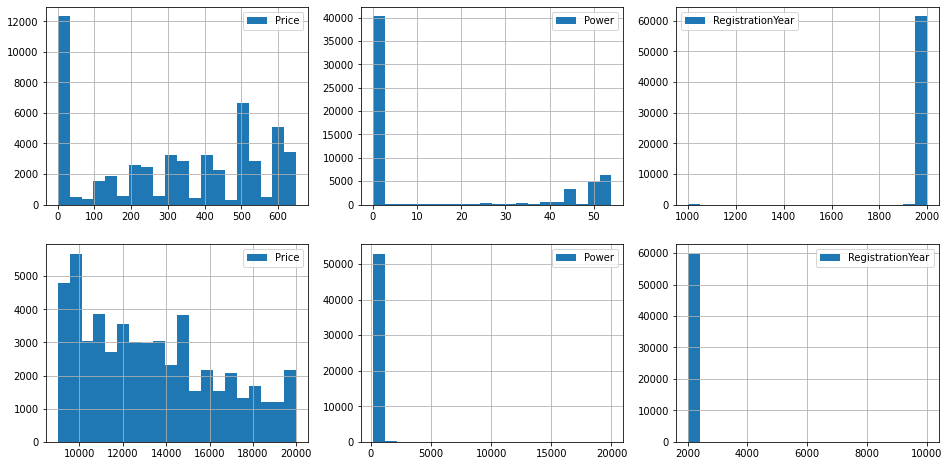

In [6]:
#Создание подграфиков:
fig, ax = plt.subplots(2, 3, figsize=(16, 8))
i = 0
for col in ['Price', 'Power', 'RegistrationYear']:
    #Подграфики для минимальных значений (до 15%-го квантиля):
    data[col].hist(bins=20, range=(data[col].min(), 
                                   data[col].quantile(0.15)), ax=ax[0, i], label=col)
    ax[0, i].legend()
    
    
    #Подграфики для максимальных значений (свыше 85%-го квантиля):
    data[col].hist(bins=20, range=(data[col].quantile(0.85), 
                                   data[col].max()), ax=ax[1, i], label=col)
    ax[1, i].legend()
    
    i += 1

Можно сделать следующие выводы:
- максимальное значение цены не является аномальным, при этом остальные рассмотренные случаи - являются;
- большое число нулевых значений цены и мощности могут быть "заглушками" - соответствующие значения не указаны. Исходя из задачи - разработки приложения для быстрой оценки автомобилей и привлечения таким образом новых клиентов следует удалить нулевые значения цены (поскольку нулевая оценка вряд ли привлечет клиента);
- аномальные значения в остальных столбцах могут быть ограничены некоторыми разумными минимальными и максимальными значениями (например значениями 0,1 и 99,9 %-ым квантилей).

### Предобработка данных

#### Обработка сведений о датах

Преобразуем данные, содержащие даты, в соответствующий тип и рассмотрим годы, месяцы и недели, соответствующие этим данным:

In [7]:
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    # Преобразование столбцов в формат даты:
    data[col] = pd.to_datetime(data[col])
    
    # Рассмотрим уникальные значения года, месяца и недели в соответствующих столбцах:
    print(col)
    print('Годы:', data[col].dt.year.unique())
    print('Месяцы:', data[col].dt.month.unique())
    print('Недели:', data[col].dt.isocalendar().week.unique(), '\n')

DateCrawled
Годы: [2016]
Месяцы: [3 4]
Недели: <IntegerArray>
[12, 11, 13, 14, 10, 9]
Length: 6, dtype: UInt32 

DateCreated
Годы: [2016 2015 2014]
Месяцы: [ 3  4  2  1 11 12  9  8  6]
Недели: <IntegerArray>
[12, 11, 13, 14, 10,  6,  9,  7,  8,  4, 45,  1,  5, 49,  3, 47, 53, 36, 46,
 52, 48, 32,  2, 33, 51, 37, 25]
Length: 27, dtype: UInt32 

LastSeen
Годы: [2016]
Месяцы: [4 3]
Недели: <IntegerArray>
[14, 11, 12, 13, 10, 9]
Length: 6, dtype: UInt32 



Данные в столбцах `DateCrawled` и `LastSeen` обладают малой вариативностью, что вызывает сомнение в информативности таких данных. Кроме того логически такие данные не должны быть связаны со стоимостью размещённого автомобиля.  
Рассмотрим разброс объявлений по цене в зависимости от даты размещения:

<AxesSubplot:xlabel='DateCreated', ylabel='Price'>

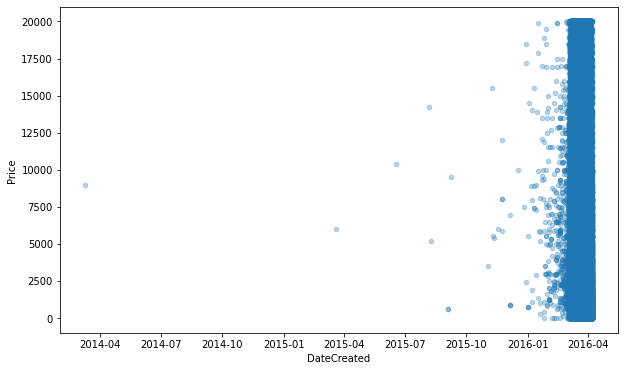

In [8]:
data.plot(x='DateCreated', y='Price', kind='scatter', alpha=0.3, figsize=(10, 6))

На период до 2016 года приходятся единичные объявления.  
Поскольку рабочая модель должна либо предсказывать изменение стоимости автомобилей со временем (что скорее всего невозможно, из-за большого числа непредсказуемых внеших факторов), либо должна регулярно перестраиваться с использованием свежих обучающих данных. Таким образом, ограничиться одним годом при построении модели вполне допустимо. Однако исключать небольшое число более старых записей не обязательно, поскольку они могут содержать информацию о редких автомобилях, то позволит построить какую-то оценку для них.   

На стоимость автомобиля потенциально может влиять сезонность, для её учета добавим данные о месяце и неделе размещения объявлений (год неинформативен, поскольку большинство объявлений приходится на 2016-ый):

In [9]:
data['DateCreatedMonth'] = data['DateCreated'].dt.month
data['DateCreatedWeek'] = data['DateCreated'].dt.isocalendar().week

Исходные столбцы с данными могут быть удалены.

#### Удаление неинформативных столбцов

Удалим неинформативный столбец `NumberOfPictures`:

In [10]:
data.drop('NumberOfPictures', axis=1, inplace=True)

Удалим неинформативные столбцы, связанные с датами:

In [11]:
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    data.drop(col, axis=1, inplace=True)

#### Обработка индексов

Данные в столбце `PostalCode` по смыслу имеют категориальный тип, однако слишком большое число различных значений (8143) мешает качественному использованию такой переменной (в зависимости от кодирования такой переменной будет либо плохое описание данных, либо слишком долгое обучение модели).  
Почтовый индекс в большинстве стран представляет собой десятичный классификатор деления территории на почтовые "регионы" и далее вплоть до районных отделений. Поскольку различия стоимости автомобилей от адреса на нижнем уровне (район города, город) маловероятны можно ограничиться первыми 2 - 3 единицами индекса. Добавим соответствующие новые переменные:

In [12]:
data['stadt'] = data['PostalCode'] // 100
data['subregion'] = data['stadt'] // 10
data['region'] = data['subregion'] // 10

Преобразуем данные в категориальный тип и удалим исходный столбец с индексами:

In [13]:
for col in ['region', 'subregion', 'stadt']:
    data[col] = data[col].astype("category")
    
data.drop('PostalCode', axis=1, inplace=True)

#### Обработка пропусков и аномалий

Заполним пропуски в категориальных данных заглушкой "NA" и преобразуем тип данных в 'categorical':

In [14]:
for col in data.columns[data.dtypes == 'object']:
    data[col].fillna('NA', inplace=True)
    data[col] = data[col].astype('category')

Обработка аномалий в столбцах 'Power', 'RegistrationYear':

In [15]:
for col in ['Power', 'RegistrationYear']:
    data.loc[data[col] < data[col].quantile(0.001), col] = data[col].quantile(0.001)
    data.loc[data[col] > data[col].quantile(0.999), col] = data[col].quantile(0.999)

Ислючение аномальных значений стоимость автомобилей:

In [16]:
before = data.shape[0]
data.drop(data.query('Price == 0').index, inplace = True)
after = data.shape[0]
print(f"Удалено {100 - 100 * after / before : 0.2f}% записей.")

Удалено  3.04% записей.


Проверим отсутствие пропусков и результат преобразования типов данных:

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343597 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              343597 non-null  int64   
 1   VehicleType        343597 non-null  category
 2   RegistrationYear   343597 non-null  float64 
 3   Gearbox            343597 non-null  category
 4   Power              343597 non-null  float64 
 5   Model              343597 non-null  category
 6   Kilometer          343597 non-null  int64   
 7   RegistrationMonth  343597 non-null  int64   
 8   FuelType           343597 non-null  category
 9   Brand              343597 non-null  category
 10  NotRepaired        343597 non-null  category
 11  DateCreatedMonth   343597 non-null  int64   
 12  DateCreatedWeek    343597 non-null  UInt32  
 13  stadt              343597 non-null  category
 14  subregion          343597 non-null  category
 15  region             343597 non-null

Пропуски отсутствуют, а типы данных соответствуют желаемым.  
Рассмотрим описательные статистики для количественных параметров:

In [18]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreatedMonth,DateCreatedWeek
count,343597.000000,343597.000000,343597.000000,343597.000000,343597.000000,343597.000000,343597.000000
mean,4555.121974,2003.188407,108.089422,128337.616452,5.777891,3.160220,11.562575
std,4515.058553,7.284475,65.694238,37521.047429,3.698186,0.376543,1.373342
min,1.000000,1957.000000,0.000000,5000.000000,0.000000,1.000000,1.000000
25%,1200.000000,1999.000000,69.000000,125000.000000,3.000000,3.000000,10.000000
50%,2890.000000,2003.000000,105.000000,150000.000000,6.000000,3.000000,12.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,3.000000,13.000000
max,20000.000000,2018.000000,700.000000,150000.000000,12.000000,12.000000,53.000000


Минимальные и максимальные значения соответствуют ожидаемым.

### Подготовка данных для обучения моделей

Разделим данные на обучающую, валидационную и тестовую выборки:

In [19]:
#Отделение тестовой выборки:
(features_train_val, features_test,
 target_train_val, target_test) = train_test_split(data[data.columns.drop('Price')],
                                                   data['Price'],
                                                   test_size = 0.25,
                                                   random_state = 123)
#Разделение обучающей и валидационной выборок:
(features_train, features_val,
 target_train, target_val) = train_test_split(features_train_val,
                                              target_train_val,
                                              test_size = 0.25,
                                              random_state = 123)

Не все модели имеют встроенную поддержку категориальных признаков, поэтому самостоятельно закодируем такие признаки.  Сначала выделим имена категориальных и количественных признаков:

In [20]:
cat_features = data.columns[data.dtypes=='category']
num_features = data.columns[data.dtypes!='category'].drop('Price')

Для большинства категориальных признаков в данной таблице лучшим выбором будет one-hot кодирование, однако для признаков, имеющих большое число вариантов лучше применить кодирование целыми числами или порядковое кодирование. Для моделей разных типов приоритетность выбора того или иного способа кодирования будет различна, для удобства напишем функцию возвращающую имена категориальных переменных с числом разных значений выше/ниже заданного:

In [21]:
# Категориальные признаки, имеющие много разных значений:
def cat_features_high_card(n, data=data):
    return data.columns[(data.nunique() > n) &  (data.dtypes == 'category')]

# Категориальные признаки, имеющие мало разных значений:
def cat_features_low_card(n, data=data):
    return data.columns[(data.nunique() <= n) &  (data.dtypes == 'category')]

print(cat_features_low_card(100))
print(cat_features_high_card(100))

Index(['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired',
       'subregion', 'region'],
      dtype='object')
Index(['Model', 'stadt'], dtype='object')


Для лучшей работы некоторых моделей (например линейных с регуляризацией) может потребоваться стандартизация количественных признаков. Во избежание ошибок объединим все преобразования в одну структуру:

In [22]:
def transformer(n):
    transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown='ignore'), cat_features_low_card(n)),
        ('label', OrdinalEncoder(handle_unknown='ignore'), cat_features_high_card(n)),
        ('scaler', StandardScaler(), num_features)
    ])
    return transformer

### Выводы

1. Представленные данные содержат небольшое количество пропусков и аномалий. 
2. Проведена подготовка данных - исключение аномалий, заполнение пропусков, удаление неинформативных параметров.
3. Исходя из заявленной задачи - предсказание цены автомобиля по описанию пользователя, исключены записи, в которых указана нулевая цена. Следует уточнить у заказчика, не подразумевалось ли иных целей разработки моделей (например предсказания какую цену *установил бы пользователь* в своем объявлении.
4. Требуется оценить скорость изменения цены автомобилей и необходимую периодичность обновления модели.

## Обучение моделей

Сравним модели различных типов:
- линейную модель с регуляризацией;
- случайный лес;
- две современные реализации градиентного бустинга.

### Линейная модель

Поскольку линейная модель не способна описывать сложные закономерности, лучшим  будет one-hot кодирование категориальных переменных. Кроме того, в случае линейной модели это не приведет к недопустимому увеличению продолжительности обучения. Будем использовать one-hot кодирования для переменых с менее чем 300 разными значениями. Для отсева неинформативных признаков воспользуемся линейной моделью с регуляризацией: 

In [23]:
%%time
model_l = Pipeline([('transform', transformer(300)), ('lasso', Lasso())])
model_l.fit(features_train, target_train)
print("Модель обучена")

Модель обучена
CPU times: user 20.7 s, sys: 200 ms, total: 20.9 s
Wall time: 20.9 s


In [24]:
%time rmse_score(model_l, features_val, target_val)

Корень из среднеквадратичной ошибки модели:  2754.3 

CPU times: user 161 ms, sys: 31.6 ms, total: 192 ms
Wall time: 249 ms


2754.3

Качество модели не удовлетворяет минимальному порогу, установленному заказчиком. Ошибка модели превышает требуемую на 10%, вероятно подбором преобразований признаков и целевой переменной (или использованием подходящего ядра в SVM) можно добить приемлемой точности. Из важных плюсов модели следует отметить быстроту обучения и предсказания (21 и 0,17 с соответственно).  
В случае высоконагруженных приложений использование подобной модели может быть актуально.  

### Случайный лес

Модель случайного леса способна хорошо описывать ступенчатые (кусочно-постоянные) зависимости, поэтому в отличии от линейной модели должна хорошо справляться с качественными переменными закодированными прозвольными числами. Учитывая значительно большую продолжительность обучения такой модели целесообразно использовать one-hot кодирование только для переменных с малым числом значений. Критическое число значений переменной (для выбора кодирования) можно рассматривать как гиперпараметр модели, его увеличение будет приводить к улучшению качества предсказаний и увеличению времени обучения/предсказания модели.  
Ограничимся переменными с числом значений до 5:

In [25]:
%%time
model_rf = Pipeline([('transform', transformer(5)), ('forest', RandomForestRegressor(n_jobs=-1, random_state=123))])
model_rf.fit(features_train, target_train)
print("Модель обучена")

Модель обучена
CPU times: user 2min 6s, sys: 1.08 s, total: 2min 7s
Wall time: 2min 8s


In [26]:
%time rmse_score(model_rf, features_val, target_val)

Корень из среднеквадратичной ошибки модели:  1659.8 

CPU times: user 3.89 s, sys: 16 ms, total: 3.91 s
Wall time: 3.92 s


1659.8

Качество модели удовлетворяет требованиям заказчика, однако время обучения и предсказания модели приблизительно на порядок превышает аналогичные параметры линейной модели. Некоторое сомнение вызывает продолжительность предсказания модели. Сократим число деревьем в лесу для ускорения работы модели:

In [27]:
%%time
model_rf_light = Pipeline([('transform', transformer(5)), 
                           ('forest', RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=123))])
model_rf_light.fit(features_train, target_train)
print("Модель обучена")

Модель обучена
CPU times: user 25.5 s, sys: 276 ms, total: 25.8 s
Wall time: 25.8 s


In [28]:
%time rmse_score(model_rf_light, features_val, target_val)

Корень из среднеквадратичной ошибки модели:  1695.6 

CPU times: user 847 ms, sys: 3.92 ms, total: 851 ms
Wall time: 856 ms


1695.6

Длительность обучения практически сравнялась с длительностью обучения линейной модели. Качество предсказаний при этом значительно лучше чем у линейной модели (но ожидаемо хуже чем у первой рассмотренной модели случайного леса).
Длительность предсказания снизилась аналогично (примерно в 5 раз), однако по прежнему сильно уступает скорости линейной модели.  
Возможна дальнейшая оптимизация модели с точки зрения точности/длительности операций, однако для однозначного выбора лучшей модели следует уточнить у заказчика критерии оптимальности.

### Градиентный бустинг

Сравним две реализации градиентного бустинга - CatBoost и LightGBM.

#### CatBoost

CatBoost имеет небольшие проблемы с использованием целочисленных количественных признаков, поэтому предварительно преобразуем тип количественных данных:

In [29]:
for features in [features_train, features_val, features_test]:
    features.loc[:, num_features] = features[num_features].astype('float64')

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1787: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


По умолчаниию CatBoostRegressor использует необходимую метрику. Максимальное число значений категориальной переменной, выше которого не используется one-hot кодирование по умолчанию равно 2, это может немного снизить точность предсказаний модели. Для лучшей сопоставимости с предыдущей моделью зададим значение гиперпараметра `one_hot_max_size` равным 5.  
Прочие гиперпараметры имеют удачное значение и для начала могут быть оставлены без изменений.

In [30]:
model_cat = CatBoostRegressor(one_hot_max_size=5,
                              verbose = 100, 
                              random_state=123
                             )

model_cat.fit(X=features_train, 
              y=target_train, 
              cat_features=list(cat_features), 
              eval_set=(features_val, target_val), 
              early_stopping_rounds=10)

print("Модель обучена")

Learning rate set to 0.116366
0:	learn: 4179.8723040	test: 4150.4227603	best: 4150.4227603 (0)	total: 487ms	remaining: 8m 6s
100:	learn: 1792.3784017	test: 1779.5409533	best: 1779.5409533 (100)	total: 30.7s	remaining: 4m 32s
200:	learn: 1708.6029166	test: 1714.3810940	best: 1714.3810940 (200)	total: 1m	remaining: 4m 1s
300:	learn: 1670.9635741	test: 1687.5001056	best: 1687.5001056 (300)	total: 1m 29s	remaining: 3m 27s
400:	learn: 1642.9242118	test: 1671.7605080	best: 1671.7605080 (400)	total: 1m 58s	remaining: 2m 57s
500:	learn: 1622.8344010	test: 1660.9033922	best: 1660.9033922 (500)	total: 2m 27s	remaining: 2m 26s
600:	learn: 1605.7304931	test: 1653.5425701	best: 1653.5425701 (600)	total: 2m 55s	remaining: 1m 56s
700:	learn: 1588.4794715	test: 1645.4615568	best: 1645.4611417 (698)	total: 3m 23s	remaining: 1m 26s
800:	learn: 1575.5312021	test: 1639.8442292	best: 1639.8442292 (800)	total: 3m 51s	remaining: 57.6s
900:	learn: 1563.6876682	test: 1635.5609491	best: 1635.5609491 (900)	total

In [31]:
%time rmse_score(model_cat, features_val, target_val)

Корень из среднеквадратичной ошибки модели:  1630.8 

CPU times: user 1.04 s, sys: 3.98 ms, total: 1.05 s
Wall time: 1.04 s


1630.8

Длительность обучения почти в два раза выше длительности обучения модели случайного леса (со 100 деревьями). 
Точность предсказаний модели несколько выше чем у модели случайного леса с большим количеством деревьев (100), а длительность предсказывания - сопоставима с длительностью работы модели малой модели случайного леса (20 деревьев).  
Окончательное решение должно быть обсуждено с заказчиком, однако можно предположить что обучение моделей происходит гораздо реже их использования, поэтому продолжительность обучения менее принципиально чем их производительность. Следовательно модель CatBoostRegressor превосходит модель случайного леса в условиях данного проекта.

Подбором гиперпараметров соотношение производительность/качество может быть дополнительно оптимизирована.

#### LightGBM

Рассматриваемые реализации градиентного бустинга крайне близки. Ограничим число итераций 900-ми, как в предыдущем случае. LightGBM позволяет при помощи гиперпараметра `zero_as_missing` указать что нули являются пропусками (в нашем случае это преимущественно так).  
Для остальных гиперпараметров оставим значения по умолчанию:

In [32]:
%%time
model_lgb = lgb.LGBMRegressor(n_estimators=900,
                              zero_as_missing=True,
                              random_state=123)

model_lgb.fit(features_train, target_train,
              eval_set=(features_val, target_val),
              callbacks=[
                  lgb.early_stopping(100),
                  lgb.log_evaluation(50)
              ]
)
print("Модель обучена")

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[50]	valid_0's l2: 2.98109e+06
[100]	valid_0's l2: 2.8255e+06
[150]	valid_0's l2: 2.77312e+06
[200]	valid_0's l2: 2.7472e+06
[250]	valid_0's l2: 2.72931e+06
[300]	valid_0's l2: 2.71623e+06
[350]	valid_0's l2: 2.70812e+06
[400]	valid_0's l2: 2.70256e+06
[450]	valid_0's l2: 2.69672e+06
[500]	valid_0's l2: 2.69346e+06
[550]	valid_0's l2: 2.69273e+06
[600]	valid_0's l2: 2.69045e+06
[650]	valid_0's l2: 2.69165e+06
[700]	valid_0's l2: 2.6898e+06
[750]	valid_0's l2: 2.69139e+06
Early stopping, best iteration is:
[691]	valid_0's l2: 2.68954e+06
Модель обучена
CPU times: user 56.3 s, sys: 216 ms, total: 56.5 s
Wall time: 57.1 s


In [33]:
%time rmse_score(model_lgb, features_val, target_val)

Корень из среднеквадратичной ошибки модели:  1640.0 

CPU times: user 5.44 s, sys: 0 ns, total: 5.44 s
Wall time: 5.49 s


1640.0

Время обучения модели значительно меньше, чем у CatBoostRegressor, при этом точность предсказания несколько хуже.  
Проблемой для предполагаемого использования представляется большая длительность предсказания - время предсказания превосходит даже показатель базовой модели случайного леса (100 деревьев).

### Выводы
1. Все рассмотренные модели кроме линейной преодолели требуемый порог точности предсказаний.
2. Лучшая точность достигнута при использовании градиентного бустинга (обе библиотеки дали приблизительно одинаковый результат).
3. Наибольшая скорость обучения при приемлемой (или близкой к лучшей) точности предсказаний достигается при помощи случайного леса малого размера и градиентного бустинга в реализации LightGBM.
4. Наибольшая скорость предсказания достигается при использовании небольшого случайного леса и бустинга в реализации CatBoost.

Таким образом, однозначно выделить лучшую модель нельзя. Требуется согласовать с заказчиком требуемые параметры периодичности обновления/производительности/точности модели.  
Исходя из планируемых целей использования (оценка стоимости авто по запросу продавца), можно предположить относительно невысокую нагрузку на систему, соответственно на первый план выходит точность модели. В таком случае оптимальной будут модели на основе градиентного бустинга (обе модели имеют в данном случае имеют практически одинаковую точность).

## Анализ моделей

Сравним ещё раз скорость и точность предсказывания рассмотренных моделей:

In [34]:
# Временные массивы для хранения времени выполнения и точности предсказаний:
times = []
rmse = []

# Расчет точности и времени выполнения для каждой модели:
for model in [model_l, model_rf, model_rf_light, model_cat, model_lgb]:
    
    #Время выполнения расчитывается как среднее по 10 запускам
    times.append(Timer("model.predict(features_val)", globals=globals()).timeit(10)/10)
    
    #Точность предсказаний рассчитывается обычным образом:
    rmse.append(rmse_score(model, features_val, target_val, show=False) )

In [35]:
results = pd.DataFrame({'Модель' :  ["Линейная", "Случайный лес", "Случайный лес (мал.)", "CatBoost", "LightGBM"],
                        'Ошибка' : rmse,
                        'Время предсказания, с' : np.round(times, 3),
                        'Время обучения, с' : [26, 128, 26, 289, 57]
})

results.sort_values(by='Ошибка')

,Модель,Ошибка,"Время предсказания, с","Время обучения, с"
3,CatBoost,1630.8,1.032,289
4,LightGBM,1640.0,5.454,57
1,Случайный лес,1659.8,3.975,128
2,Случайный лес (мал.),1695.6,0.800,26
0,Линейная,2754.3,0.143,26


На валидационной выборке все модели кроме линейной удовлетворяют требованиям заказчика по минимальной точности. Лучшая точность была получена для модели на базе CatBoost. Такая модель имеет удовлетворительную скорость предсказания, однако также имеет самую низкую скорость обучения.  
Как было отмечено выше для окончательного выбора следует уточнить у заказчика требования к производительности разрабатываемой модели.  
Учитывая характер использования модели можно предположить большую нагрузку при обучении модели в сравнении с её использованием. При этом скорость работы модели более важна именно на стадии предсказаний и большая сложность обучения может быть до определенной степени проигнорирована. Выбирая исходя из точности модели и ограничиваясь не самым большим временем предсказания следует выбрать модель на основе CatBoost.

**Проверим модель на основе CatBoost на тестовых данных:**

In [36]:
%time rmse_score(model_cat, features_test, target_test)

Корень из среднеквадратичной ошибки модели:  1652.6 

CPU times: user 1.46 s, sys: 4.17 ms, total: 1.46 s
Wall time: 1.46 s


1652.6

Производительность модели несколько упала по сравнению с предсказаниями на валидационной выборке, однако по прежнему остаётся на удовлетворительном уровне.  
Точность предсказаний несколько снижена по сравнению с валидацией, но также удовлетворяет требованием заказчика.

## Выводы

1. Лучшей моделью в рамках проекта оказалась модель на основе CatBoost. Модель умеет удовлетворительную производительность при предсказании стоимости автомобитель и обеспечивает лучшую точность предсказаний среди всех рассмотренных моделей.
2. Близкие результаты по точности предсказаний показали модели градиентного бустинга и случайного леса.
2. Лучшей производительностью при обучении обладает модель LightGBM, а при предсказании - CatBoost.
3. Выбор конкретной модели и оптимизации её гиперпараметров требуют уточнения у заказчика предъявляемых к модели требований по скорости работы и точности, для формирования единой композиционной метрики качества.  
Требуется понимание планируемой посещаемости ресурса, стоимости ошибки предсказания и серверного времени а также объема базы для построения модели.
4. Также требуется уточнить является ли задачей модели предсказание адекватной цены автомобиля, или цены, которую бы установил пользователь при создании объявления.